# Moon - Earth Collision (Here Comes the Moon)

## Emma and Michael

In [13]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim library
from modsim import *
import math

## Question

The moon currently has a stable orbit around the earth, only drifting outwards by 4 cm a year. But what if we wanted to throw off that orbit completely?

Fred is an Olin first-year student who, well, let’s just say he enjoys being at school, but his work is not quality enough to give him a competitive edge in the real world. Luckily, he’s self-aware enough to realize this problem. He figures the only reasonable solution is to end the world on the day of his graduation from Olin (May 20, 2018) by crashing the moon into the earth.

His plan is to crash large amounts of replicas of Saturn V rockets into the moon. The effects of these rockets are twofold. First off, the mass transferred from the earth to the moon in the form of rockets will increase the gravitational force between the two bodies, as described by the Law of Universal Gravitation. Secondly, the rockets crash into the moon’s orbital path, thus slowing the moon down, decreasing its momentum and its ability to hold a stable orbit around the earth.

Before he can start on the non-trivial task of raising money for his creation of these rockets (his kickstarter goal may well be larger than the sum total of the economic production of the human race since the beginning of time), he must answer the question,

### How many rockets per second must hit the moon, starting December 14, 2018, to cause the moon to crash into the earth on May 20, 2022?


## Model

In Fred’s version of our universe, everything is flat (2-d) and only the moon and earth exist (i.e. the sun is not a part of the model, nor are the other planets of our solar system). The moon and earth both exert gravitational force on and move around each other. They are modeled as a two body system while ignoring other bodies as a trade-off between realism and simplicity. As a result, the effect of the earth and moon on each other is considered, but effect of the sun is ignored.

![title](schematic.jpg)

The earth and moon were in a realistic, stable orbit until Fred began launching rockets into the moon’s orbital path, increasing its mass to eventually cause it to fall to the Earth. Fred’s system for launching rockets miraculously transports the mass from the Earth without changing the Earth’s momentum, so the earth's mass decreases at the same rate that the moon's mass increases.

We begin with establishing parameters for the model. The masses of the earth and the moon reflect actual values, and the moon’s initial position and velocity are that of its perigee. earth_radius and moon radius are functions that calculate the radii based on the bodies’ masses, which are constantly changing. It also contains the number of rockets sent to the moon per second, which is the parameter we are trying to optimize.

In [14]:
def earth_radius(mass):
    """Computes earth's radius from its mass.
    
    mass: earth's mass in kg
    Returns: radius in meters
    """
    density = 5514 # 5514 kg/m3 from NASA Earth Fact Sheet
    Re = (3*mass / (4*pi*density))**(1/3)
    return Re

def moon_radius(mass):
    """Computes moon's radius from its mass.
    
    mass: moon's mass in kg
    Returns: radius in meters
    """
    density = 3344 # 3344 kg/m3 from NASA Moon Fact Sheet
    Rm = (3*mass / (4*pi*density))**(1/3)
    return Rm

In [15]:
params = Params(num_rockets = 2.4448e+08,
                r_e = earth_radius,
                r_m = moon_radius,
                G=6.674e-11, #N / kg**2 * m**2
                t_0=0,
                t_end=5*365*24*60*60, 
                x_0 = 362600000, # 362,600 km at perigee
                v_0 = 1078.2, # 1078.2 m/s at perigee
                Me_0 = 5.9722e24, # 5.9722×10^24 kg
                Mm_0 = 7.342e22); # 7.342×10^22 kg

The model’s System object contains its parameters, including dmdt, which is the mass rate of change of the moon as caused by the rockets being sent to it. Note that the earth is losing mass at the same rate. The initial condition of the simulation is includes the masses and the x and y positions and velocities of the moon and the earth.

In [16]:
def make_system(params):
    """Creates system object 
    
    params: Params object 
    Returns: System object with initial state and params
    """
    num_rockets, r_e, r_m, G, t_0, t_end, x_0, v_0, Me_0, Mm_0 = params
    
    dmdt = 6.54e6*num_rockets
    
    init = State(Me = Me_0, # Initial mass of earth
             Mm = Mm_0, #Initial mass of moon
             x_m=x_0, # 362,600 km at perigee
             y_m=0,
             vx_m=0,
             vy_m=v_0, # 1078.2 m/s at perigee
             x_e = 0,
             y_e = 0,
             vx_e = 0,
             vy_e = 0
            )
    system = System(init = init,
                dmdt =dmdt,
                r_e = earth_radius,
                r_m = moon_radius,
                r_escape = 10*0.4055e9,    
                G=6.674e-11, #N / kg**2 * m**2
                t_0=0,
                t_end=5*365*24*60*60, 
                x_0 = 362600000, # 362,600 km at perigee
                v_0 = 1078.2, # 1078.2 m/s at perigee
                Me_0 = 5.9722e24, # 5.9722×10^24 kg
                Mm_0 = 7.342e22) # 7.342×10^22 kg
    
    return system

The net force on the moon is made up two forces:
- The force of gravitation
    - This is calculated using the Universal Law of Gravitation.
- The force of the collision with rockets, conserving momentum
    - This is equivalent to the mass sent to the moon times the negative of its velocity.

![title](diffeq1.png)

In [17]:
def net_force_moon(state, system):
    """Computes gravitational force on the moon.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    
    returns: vector
    """
    Me,Mm,x_m,y_m,vx_m,vy_m,x_e,y_e,vx_e,vy_e = state
    unpack(system)
    
    #Gravitational Force
    r = sqrt((x_m-x_e)**2 + (y_m-y_e)**2)
    force= G * Me * Mm / r**2
    direction = math.atan2(y_m-y_e,x_m-x_e) + pi 
    gravitational_force = Vector(force * math.cos(direction), force*math.sin(direction) )
    
    # Moon momentum contribution
    collision_force = dmdt * -(Vector(vx_m,vy_m))
    
    return gravitational_force + collision_force

There is only one force on the earth, the gravitational pull of the moon. This is once again calculated using the Law of Universal Gravitation.

![title](diffeq2.png)

In [18]:
def net_force_earth(state, system):
    """Computes gravitational force on the earth.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    
    returns: vector
    """
    Me,Mm,x_m,y_m,vx_m,vy_m,x_e,y_e,vx_e,vy_e = state
    unpack(system)
    
    #Gravitational Force
    r = sqrt((x_m-x_e)**2 + (y_m-y_e)**2)
    force= G * Me * Mm / r**2
    direction = math.atan2(y_m-y_e,x_m-x_e)
    gravitational_force = Vector(force * math.cos(direction), force*math.sin(direction) )
    
    return gravitational_force

Each time step forward is calculated by the slope function. It updates the masses of the earth and the moon, as well as their position and velocity in two dimensions. To do so, it calls the net force functions and uses F = MA to calculate the change in velocity within the time step.

In [19]:
def slope_func(state,t,system):
    """Calculates change in earth's and moon's mass, position and velocity over one timestep
    
    state: State object with earth's and moon's mass, position and velocity (scalar)
    t: time within simulation
    system: System object with simulation parameters
    
    returns: change in earth's and moon's mass, position and velocity (scalars)"""
    
    Me,Mm,x_m,y_m,vx_m,vy_m,x_e,y_e,vx_e,vy_e = state
    unpack(system)
    V_m = Vector(vx_m,vy_m)
    V_e = Vector(vx_e,vy_e)
    
    Fnet_m = net_force_moon(state,system)
    Fnet_e = net_force_earth(state,system)
    
    dMedt = -dmdt
    dMmdt = dmdt
    dxdt_m = V_m
    dvdt_m = Fnet_m / Mm
    dxdt_e = V_e
    dvdt_e = Fnet_e / Me
    
    return dMedt, dMmdt, dxdt_m[0], dxdt_m[1], dvdt_m[0], dvdt_m[1], dxdt_e[0], dxdt_e[1], dvdt_e[0], dvdt_e[1],

The simulation ends, as defined by the event func, when:
- The surfaces of the moon and earth collide (the distance between the centers of the bodies are less than the sum of their radii)
- The earth has negative mass
- The distance between the moon and the earth reaches ten times its apogee value

In [20]:
def event_func(state,t,system):
    """Returns 0 when earth and moon collide, earth reaches negative mass, or moon 
       reaches 10x its apogee value 
       
    state: State object with earth's and moon's mass, position and velocity (scalar)
    t: time within simulation
    system: System object with simulation parameters
    """
    
    Me,Mm,x_m,y_m,vx_m,vy_m,x_e,y_e,vx_e,vy_e = state
    unpack(system)
   
    r = sqrt((x_m-x_e)**2 + (y_m-y_e)**2)
    collision_radius = earth_radius(Me) + moon_radius(Mm)
    
    #End the simulation if there is a collision OR if the orbital radius exceeds its initial value at apogee
    if(Me < 0):
        print('Negative mass is really sad...')
        return 0
    elif(r > r_escape):
        print('The moon escaped our experiment!')
        return 0
    else:
        return r - collision_radius


A single run of the simulation is demonstrated below, with a billion rockets per second thrown at the moon.

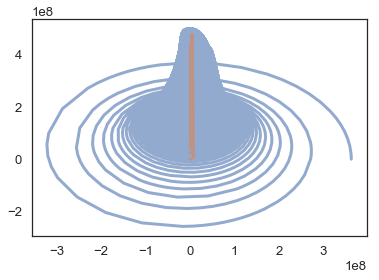

In [21]:
params = Params(params, num_rockets=1e9)
system = make_system(params)
results, details = run_ode_solver(system, slope_func, events=event_func, method="LSODA")
results.index /= 24*60*60*365

plot(results.x_m,results.y_m)
plot(results.x_e,results.y_e);

In [22]:
results.index[-1]

1.169491265876398

The moon crashes into the earth in a bit over a year, which means the mass rate of change is too high. To determine the number of rockets per second that will cause the moon to crash on graduation (3.52 years), we need to sweep num_rockets to get the right result.

## Results

An error function runs the simulation, and returns the difference between the target collision day and simulation collision day. Giving the error function an array of values allows us to narrow our possibilities down to a solution.

In [30]:
def error_func(rockets, params):
    """Calculates error between ideal crash time and simulated crash time given number of rockets
    
    rockets:  number of rockets
    params: system parameters
    
    returns: scalar"""
    
    params = Params(params, num_rockets=rockets)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func, method="LSODA")
    results.index /= 24*60*60*365
    return (results.index[-1] - 3.52)

In [31]:
def sweep_rockets(rocket_array):
    """Calculates ideal versus siumlated crash time error through a range of rocket numbers
    
    rocket_array: array containing a range of rocket values
    
    returns: SweepSeries"""
    
    sweep = SweepSeries()
    for rock in rocket_array:
        error = error_func(rock, params)*365
        #print(rock, dday)
        sweep[rock] = error
    
    plot(sweep, color='C2')
    decorate(xlabel='Number of Rockets (count)',
         ylabel='Error (days)',
         title='Time vs Number of Rockets',
         legend=False)
    
    return sweep

Starting with a large sweep, the solution seems to be somewhere around 200 million Saturn V rockets per second.

Wall time: 6min 59s


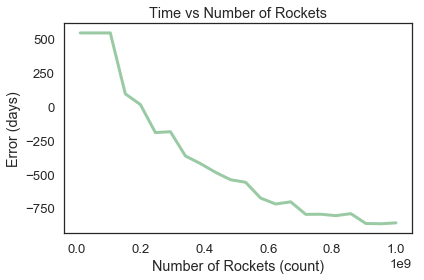

In [32]:
large_sweep_array = linspace(1e7, 1e9, 22)
%time sweep = sweep_rockets(large_sweep_array)

To close in on the optimal number of rockets, we sweep through a narrow range of values.

Wall time: 8min 41s


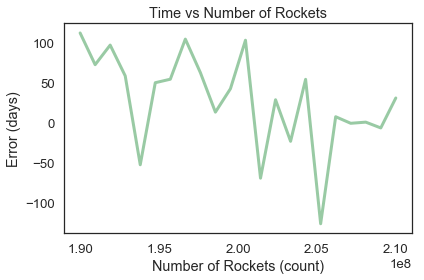

In [34]:
narrow_sweep_array = linspace(1.9e8, 2.1e8, 22)
%time sweep2 = sweep_rockets(narrow_sweep_array)

After zooming in on the solution area, the exact answer is elusive; it appears to be somewhere between 190 and 210 million rockets per second with a tolerance of +/- 5% where the error is closest to zero.

## Interpretation

Things to talk about:
 - Obscenely high number of rockets --> obscenely high cost
 - Uncertainty: different ode solver methods acting differently, error line not smooth 
 - Rockets running into moon math might be weird

## Code we are not currently using

In [27]:
def fsolve2(func, x0, *args, **options):
    """Return the roots of the (non-linear) equations
    defined by func(x) = 0 given a starting estimate.

    Uses scipy.optimize.fsolve, with extra error-checking.

    func: function to find the roots of
    x0: scalar or array, initial guess
    args: additional positional arguments are passed along to fsolve,
          which passes them along to func

    returns: solution as an array
    """
    # make sure we can run the given function with x0
    try:
        func(x0, *args)
    except Exception as e:
        msg = """Before running scipy.optimize.fsolve, I tried
                 running the error function you provided with the x0
                 you provided, and I got the following error:"""
        logger.error(msg)
        raise(e)

    # make the tolerance more forgiving than the default
    underride(options, xtol=1e-2)

    x0 = magnitude(x0)

    # run fsolve
    with units_off():
        result = scipy.optimize.fsolve(func, x0, args=args, **options)

    return result

In [28]:
%time res = min_bounded(error_func, [1e7, 1e10], params)

Wall time: 12min 41s
